In [14]:
# load relevant packages for analysis
import ast
import cityseer as cs
import cityseer.tools.graphs as cityseer_graphs
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import graph_tool.all as gt
import geopandas as gpd
import igraph
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import numpy as np
import networkx as nx
import osmnx as ox
import os
import pandas as pd
import pyogrio
import random
import seaborn as sns
from scipy.stats import entropy
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point, MultiPoint, Polygon
from shapely.geometry import LineString, MultiLineString
from shapely.ops import nearest_points
import shapely.wkt
from shapely.wkt import loads
from shapely import wkt
import statsmodels.api as sm
import sys
from tqdm import tqdm
from xml import etree

## 1. Read & Inspect Datasets

## 1. Read in Datasets

In [3]:
gdf = gpd.read_file('Data/clusterinfo_gdf.gpkg')

In [4]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   cluster_id            534 non-null    int64   
 1   node_count            534 non-null    int64   
 2   diameter              534 non-null    float64 
 3   cc_avg_dir            534 non-null    object  
 4   cc_avg_undir          534 non-null    object  
 5   prop_3way             534 non-null    float64 
 6   prop_4way             534 non-null    float64 
 7   prop_deadend          534 non-null    float64 
 8   pagerank_max          534 non-null    float64 
 9   self_loop_proportion  534 non-null    float64 
 10  orientation_entropy   534 non-null    float64 
 11  orientation_order     534 non-null    float64 
 12  geometry              534 non-null    geometry
dtypes: float64(8), geometry(1), int64(2), object(2)
memory usage: 54.4+ KB


In [6]:
G_nx = nx.read_graphml("Data/G_nx.graphml")

In [7]:
list(G_nx.edges(data=True))[:10]

[('3C8D3199-B498-462C-A14B-886484E4D116',
  '7865FC3D-B352-47C0-8F68-FC1E3B1BED36',
  {'length': 82.0,
   'road_classification': 'Classified Unnumbered',
   'road_function': 'Minor Road',
   'form_of_way': 'Single Carriageway',
   'primary_route': 0,
   'trunk_road': 0,
   'geometry': 'LINESTRING (337517 401530, 337541.4 401538.63, 337565.8 401547.25, 337580.4 401551.63, 337595 401556)',
   'betweenness': 0.003395585738539898}),
 ('3C8D3199-B498-462C-A14B-886484E4D116',
  '695446BB-69FB-4807-81B0-98A6E91ED77A',
  {'length': 10.0,
   'road_classification': 'Classified Unnumbered',
   'road_function': 'Minor Road',
   'form_of_way': 'Single Carriageway',
   'primary_route': 0,
   'trunk_road': 0,
   'geometry': 'LINESTRING (337507 401527, 337512 401528.5, 337517 401530)',
   'betweenness': 0.01015210838155296}),
 ('3C8D3199-B498-462C-A14B-886484E4D116',
  'AAEAFCCD-8BA0-47A2-99B9-5AEC4007AEEA',
  {'length': 212.0,
   'road_classification': 'Unclassified',
   'road_function': 'Local Road'

In [8]:
list(G_nx.nodes(data=True))[0]

('3C8D3199-B498-462C-A14B-886484E4D116',
 {'pos': '337517.0,401530.0',
  'angle': 158.57643500780435,
  'form_of_road_node': 'junction',
  'geometry': 'POINT (337517 401530)',
  'degree': 3,
  'closeness': 0.043568464730290454})

In [9]:
retail_gdf = gpd.read_file('Data/filtered_retail_locations.gpkg')

## 2. Transfer 'Closeness' Attribute to G_nx

G_Closeness includes an essentiall attribute for our analysis that is the closeness centrality attributes for nodes in our street network.

In the follwing code we add this attribute to *G_nx* and save. Once *Closeness* is added we will then have a graph with the following Calculated attributes:
- **Nodes:**
    - Angle
    - Closeness Centrality
    - geometry
    - Degree
 - **Edges**
     - Length
     - Betweeness
  
We will use these node and edge level attributes in combination with the city level metrics we have calculated to understand the Boeing's Topological Metrics which are highly correlated with retail density.

### Load Cleaned Retail Data

In [10]:
print(retail_gdf.head())

             groupname                           categoryname pointx_class  \
0  Commercial Services  Personal, Consumer and Other Services     02100167   
1  Commercial Services  Personal, Consumer and Other Services     02100167   
2  Commercial Services  Personal, Consumer and Other Services     02100167   
3  Commercial Services  Personal, Consumer and Other Services     02100167   
4  Commercial Services  Personal, Consumer and Other Services     02100167   

                                          classname  \
0  Headquarters, Administration and Central Offices   
1  Headquarters, Administration and Central Offices   
2  Headquarters, Administration and Central Offices   
3  Headquarters, Administration and Central Offices   
4  Headquarters, Administration and Central Offices   

                        geometry  
0  POINT (317873.000 177213.000)  
1  POINT (408036.000 289239.000)  
2  POINT (354227.000 430091.000)  
3   POINT (412181.800 91973.600)  
4  POINT (319615.600 1748

In [11]:
retail_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 398925 entries, 0 to 398924
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   groupname     398925 non-null  object  
 1   categoryname  398925 non-null  object  
 2   pointx_class  398925 non-null  object  
 3   classname     398925 non-null  object  
 4   geometry      398925 non-null  geometry
dtypes: geometry(1), object(4)
memory usage: 15.2+ MB


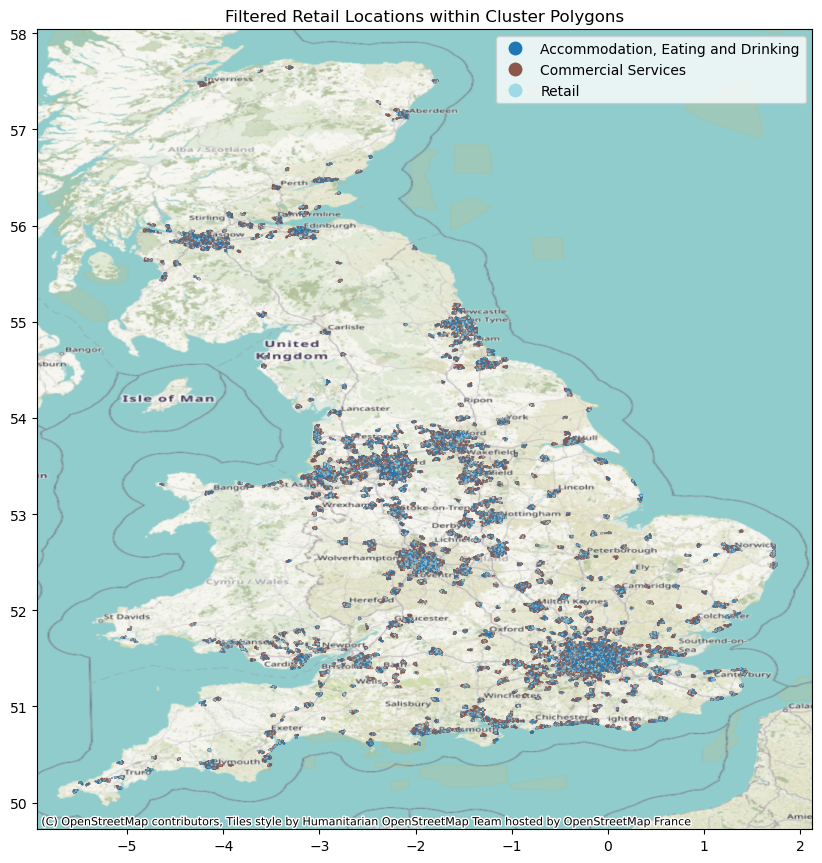

In [51]:
retail_gdf = retail_gdf.to_crs(epsg=4326)

# Plot the filtered gdf
fig, ax = plt.subplots(figsize=(10, 20))
retail_gdf.plot(column='groupname', ax=ax, legend=True, legend_kwds={'bbox_to_anchor': (1, 1)}, markersize=0.1, cmap='tab20')

# Add basemap with proper handling for CRS
ctx.add_basemap(ax, crs=retail_gdf.crs.to_string())

plt.title('Filtered Retail Locations within Cluster Polygons')
plt.show()

### Prepare Edges GDF with avg closeness,  angle 

In [67]:
import geopandas as gpd
from shapely import wkt

# Convert node geometries to GeoDataFrame
node_data = []
for node, data in G_nx.nodes(data=True):
    try:
        geom = wkt.loads(data['geometry'])
    except KeyError:
        geom = None  # Or handle it appropriately if 'geometry' is missing

    node_data.append({
        'node_id': node,
        'geometry': geom,
        'pos': data.get('pos', None),
        'closeness': data.get('closeness', None),
        'degree': data.get('degree', None),
        'angle': data.get('angle', None),
        'form_of_road_node': data.get('form_of_road_node', None)
    })

nodes_gdf = gpd.GeoDataFrame(node_data, geometry='geometry', crs='EPSG:27700')

# Convert edge geometries to GeoDataFrame
edge_data = []
for u, v, data in G_nx.edges(data=True):
    # Create a unique edge identifier
    edge_id = f"{u}_{v}"
    edge_entry = {
        'edge_id': edge_id,  # Unique identifier for the edge
        'geometry': wkt.loads(data.get('geometry', 'LINESTRING EMPTY')),
        'length': data.get('length', None),
        'betweenness': data.get('betweenness', None),
        'road_classification': data.get('road_classification', None),
        'road_function': data.get('road_function', None),
        'form_of_way': data.get('form_of_way', None),
        'primary_route': data.get('primary_route', None),
        'trunk_road': data.get('trunk_road', None)
    }
    edge_data.append(edge_entry)

edges_gdf = gpd.GeoDataFrame(edge_data, geometry='geometry', crs='EPSG:27700')

# Add average closeness, average degree, and average angle to edges
for u, v, data in G_nx.edges(data=True):
    closeness_u = G_nx.nodes[u].get('closeness', None)
    closeness_v = G_nx.nodes[v].get('closeness', None)
    degree_u = G_nx.nodes[u].get('degree', None)
    degree_v = G_nx.nodes[v].get('degree', None)
    angle_u = G_nx.nodes[u].get('angle', None)
    angle_v = G_nx.nodes[v].get('angle', None)

    # Calculate average closeness
    if closeness_u is not None and closeness_v is not None:
        data['avg_closeness'] = (closeness_u + closeness_v) / 2
    else:
        data['avg_closeness'] = None

    # Calculate average degree
    if degree_u is not None and degree_v is not None:
        data['avg_degree'] = (degree_u + degree_v) / 2
    else:
        data['avg_degree'] = None

    # Calculate average angle
    if angle_u is not None and angle_v is not None:
        data['avg_angle'] = (angle_u + angle_v) / 2
    else:
        data['avg_angle'] = None

# Convert updated edge attributes to GeoDataFrame
edges_data = []
for u, v, data in G_nx.edges(data=True):
    edge_id = f"{u}_{v}"  # Ensure the edge_id is correctly defined within the loop
    edges_data.append({
        'edge_id': edge_id,
        'geometry': wkt.loads(data['geometry']),
        'length': data['length'],
        'betweenness': data['betweenness'],
        'road_classification': data['road_classification'],
        'road_function': data['road_function'],
        'form_of_way': data['form_of_way'],
        'primary_route': data['primary_route'],
        'trunk_road': data['trunk_road'],
        'avg_closeness': data['avg_closeness'],
        'avg_degree': data['avg_degree'],
        'avg_angle': data['avg_angle']
    })

edges_gdf = gpd.GeoDataFrame(edges_data, geometry='geometry', crs='EPSG:27700')

# Verify the new attributes
edges_gdf.head()

,edge_id,geometry,length,betweenness,road_classification,road_function,form_of_way,primary_route,trunk_road,avg_closeness,avg_degree,avg_angle
0,3C8D3199-B498-462C-A14B-886484E4D116_7865FC3D-...,"LINESTRING (337517.000 401530.000, 337541.400 ...",82.0,0.003396,Classified Unnumbered,Minor Road,Single Carriageway,0,0,0.047601,3.5,181.128005
1,3C8D3199-B498-462C-A14B-886484E4D116_695446BB-...,"LINESTRING (337507.000 401527.000, 337512.000 ...",10.0,0.010152,Classified Unnumbered,Minor Road,Single Carriageway,0,0,0.049891,3.0,180.231411
2,3C8D3199-B498-462C-A14B-886484E4D116_AAEAFCCD-...,"LINESTRING (337517.000 401530.000, 337519.000 ...",212.0,0.003396,Unclassified,Local Road,Single Carriageway,0,0,0.044559,3.0,198.874539
3,AAEAFCCD-8BA0-47A2-99B9-5AEC4007AEEA_54EF0B8A-...,"LINESTRING (337468.000 401329.000, 337511.000 ...",125.0,0.041227,Unclassified,Local Road,Single Carriageway,0,0,0.046627,3.0,173.610247
4,AAEAFCCD-8BA0-47A2-99B9-5AEC4007AEEA_F5387DFA-...,"LINESTRING (337468.000 401329.000, 337440.000 ...",369.0,0.037601,Unclassified,Local Road,Single Carriageway,0,0,0.047084,3.0,238.732815


In [19]:
edges_gdf['edge_id'].nunique()

2050671

### Conduct snapping

In [68]:
from rtree import index
# Build spatial index
spatial_index = index.Index()

# Iterate over each row in the GeoDataFrame
for idx, row in edges_gdf.iterrows():
    # Insert the geometry bounds into the spatial index
    spatial_index.insert(idx, row.geometry.bounds)

In [69]:
def snap_pois_to_edges(pois_gdf, edges_gdf, spatial_index, max_snap_distance=25):
    snapped_pois = []

    for idx, poi in pois_gdf.iterrows():
        poi_geom = poi.geometry
        min_dist = max_snap_distance
        nearest_edge = None
        snapped_point = None

        # Use spatial index to find candidate edges within bounding box
        candidate_edge_indices = list(spatial_index.nearest(poi_geom.bounds, 10))

        for edge_idx in candidate_edge_indices:
            edge = edges_gdf.iloc[edge_idx]
            edge_geom = edge.geometry
            point_on_edge = nearest_points(poi_geom, edge_geom)[1]
            dist = poi_geom.distance(point_on_edge)

            if dist < min_dist:
                min_dist = dist
                nearest_edge = edge
                snapped_point = point_on_edge

        if nearest_edge is not None:
            # Combine POI information with nearest edge information
            snapped_pois.append({
                'poi_id': idx,  # Use the index or another unique identifier if available
                'original_geometry': poi_geom,
                'snapped_geometry': snapped_point,
                'groupname': poi['groupname'],
                'categoryname': poi['categoryname'],
                'pointx_class': poi['pointx_class'],
                'classname': poi['classname'],

                # Edge attributes
                'edge_id': nearest_edge.edge_id,  # Ensure you have a unique identifier for edges
                'edge_geometry': nearest_edge.geometry,
                'edge_length': nearest_edge.length,
                'edge_betweenness': nearest_edge.betweenness,
                'edge_road_classification': nearest_edge.road_classification,
                'edge_road_function': nearest_edge.road_function,
                'edge_form_of_way': nearest_edge.form_of_way,
                'edge_primary_route': nearest_edge.primary_route,
                'edge_trunk_road': nearest_edge.trunk_road,
                'edge_avg_closeness': nearest_edge.avg_closeness,
                'edge_avg_degree': nearest_edge.avg_degree,
                'edge_avg_angle': nearest_edge.avg_angle
            })

    snapped_pois_gdf = gpd.GeoDataFrame(snapped_pois, geometry='snapped_geometry', crs=pois_gdf.crs)
    return snapped_pois_gdf

# Run the function
snapped_pois_gdf = snap_pois_to_edges(retail_gdf, edges_gdf, spatial_index)

# Display the result
snapped_pois_gdf.head()

ValueError: Unknown column snapped_geometry

In [48]:
from shapely.ops import nearest_points

def snap_pois_to_edges(pois_gdf, edges_gdf, spatial_index, max_snap_distance=25):
    snapped_pois = []

    for idx, poi in pois_gdf.iterrows():
        poi_geom = poi.geometry
        min_dist = max_snap_distance
        nearest_edge = None
        snapped_point = None

        # Use spatial index to find candidate edges within bounding box
        candidate_edge_indices = list(spatial_index.nearest(poi_geom.bounds, 10))

        for edge_idx in candidate_edge_indices:
            edge = edges_gdf.iloc[edge_idx]
            edge_geom = edge.geometry
            point_on_edge = nearest_points(poi_geom, edge_geom)[1]
            dist = poi_geom.distance(point_on_edge)

            if dist < min_dist:
                min_dist = dist
                nearest_edge = edge
                snapped_point = point_on_edge

        if nearest_edge is not None:
            # Combine POI information with nearest edge information
            snapped_pois.append({
                'poi_id': idx,  # Use the index or another unique identifier if available
                'original_geometry': poi_geom,
                'snapped_geometry': snapped_point,
                'groupname': poi['groupname'],
                'categoryname': poi['categoryname'],
                'pointx_class': poi['pointx_class'],
                'classname': poi['classname'],

                # Edge attributes
                'edge_id': nearest_edge.edge_id,
                'edge_geometry': nearest_edge.geometry,
                'edge_length': nearest_edge.length,
                'edge_betweenness': nearest_edge.betweenness,
                'edge_road_classification': nearest_edge.road_classification,
                'edge_road_function': nearest_edge.road_function,
                'edge_form_of_way': nearest_edge.form_of_way,
                'edge_primary_route': nearest_edge.primary_route,
                'edge_trunk_road': nearest_edge.trunk_road,
                'edge_avg_closeness': nearest_edge.avg_closeness,
                'edge_avg_degree': nearest_edge.avg_degree,
                'edge_avg_angle': nearest_edge.avg_angle
            })

    snapped_pois_gdf = gpd.GeoDataFrame(snapped_pois, geometry='snapped_geometry', crs=pois_gdf.crs)
    return snapped_pois_gdf

# Run the function
snapped_pois_gdf = snap_pois_to_edges(retail_gdf, edges_gdf, spatial_index)

# Display the result
snapped_pois_gdf.head()

ValueError: Unknown column snapped_geometry

In [54]:
def plot_snapped_pois(retail_gdf, edges_gdf, snapped_pois_gdf):
    fig, ax = plt.subplots(figsize=(30, 20))
    
    # Plot street lines
    edges_gdf.plot(ax=ax, color='blue', linestyle='-', linewidth=0.1, alpha=0.7, label='Street Network')
    
    # Plot POIs
    retail_gdf.plot(ax=ax, color='red', markersize=0.001, label='Original POIs')
    
    # Plot snapped POIs
    snapped_pois_gdf.plot(ax=ax, color='green', markersize=0.001, label='Snapped POIs')
    
    # Draw lines from snapped POIs to their nearest edges
    for _, row in snapped_pois_gdf.iterrows():
        poi = row['original_geometry']
        snapped_point = row['snapped_geometry']
        ax.plot([poi.x, snapped_point.x], [poi.y, snapped_point.y], color='orange', linestyle='--', linewidth=0.1, alpha=0.7)

    ax.set_title("Snapped POIs and Street Network")
    ax.legend()
    plt.show()

# plot
plot_snapped_pois(retail_gdf, edges_gdf, snapped_pois_gdf)

NameError: name 'snapped_pois_gdf' is not defined

In [ ]:
def check_snap_distances(snapped_pois_gdf):
    distances = []
    for _, row in snapped_pois_gdf.iterrows():
        original_geom = row['original_geometry']
        snapped_geom = row['snapped_geometry']
        distance = original_geom.distance(snapped_geom)
        distances.append(distance)

    # summary statistics
    print(f"Maximum snapping distance: {max(distances)} meters")
    print(f"Minimum snapping distance: {min(distances)} meters")
    print(f"Average snapping distance: {sum(distances) / len(distances)} meters")

# Call the function to check distances
check_snap_distances(snapped_pois_gdf)

In [ ]:
# Calculate snapping distances
snapped_pois_gdf['distance'] = snapped_pois_gdf.apply(lambda row: row['original_geometry'].distance(row['snapped_geometry']), axis=1)

In [ ]:
# Get descriptive statistics
distance_stats = snapped_pois_gdf['distance'].describe()
distance_stats

In [ ]:
# Plot histogram of distances
plt.figure(figsize=(10, 6))
plt.hist(snapped_pois_gdf['distance'], bins=30, edgecolor='black')
plt.title('Distribution of Snapping Distances')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Plot KDE of distances
plt.figure(figsize=(10, 6))
sns.kdeplot(snapped_pois_gdf['distance'], shade=True, color='blue')
plt.title('Kernel Density Estimate of Snapping Distances')
plt.xlabel('Distance (meters)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [ ]:
snapped_pois_gdf.info()

In [ ]:
# Define a threshold for high outliers (e.g., 95th percentile or a specific distance)
threshold_distance = snapped_pois_gdf['distance'].quantile(0.97)

# Filter for high outliers
high_outliers = snapped_pois_gdf[snapped_pois_gdf['distance'] > threshold_distance]

print(f"Number of high outliers: {len(high_outliers)}")
high_outliers

In [ ]:
snapped_pois_gdf.columns

In [64]:
def aggregate_pois_on_streets(snapped_pois_gdf, edges_gdf):
    # Ensure that the 'edge_id' column exists in snapped_pois_gdf
    if 'edge_id' not in snapped_pois_gdf.columns:
        raise ValueError("The 'snapped_pois_gdf' does not contain the 'edge_id' column.")
    
    # Group by 'edge_id' and count the number of POIs per edge
    poi_counts = snapped_pois_gdf.groupby('edge_id').size().reset_index(name='poi_count')
    
    # Ensure 'edge_id' exists in edges_gdf and merge the counts with the edges GeoDataFrame
    if 'edge_id' not in edges_gdf.columns:
        raise ValueError("The 'edges_gdf' does not contain the 'edge_id' column.")
    
    merged_edges = edges_gdf.merge(poi_counts, on='edge_id', how='left')
    
    # Fill NaN values in 'poi_count' with 0 if needed
    merged_edges['poi_count'].fillna(0, inplace=True)
    
    # Ensure distance is calculated correctly
    merged_edges['distance'] = merged_edges.geometry.length
    
    # Convert the merged data to a GeoDataFrame
    aggregated_edges_gdf = gpd.GeoDataFrame(merged_edges, geometry='geometry', crs=snapped_pois_gdf.crs)
    
    return aggregated_edges_gdf

# Run the aggregation function
aggregated_edges_gdf = aggregate_pois_on_streets(snapped_pois_gdf, edges_gdf)

NameError: name 'snapped_pois_gdf' is not defined

In [63]:
def describe_poi_distribution(gdf):
    # Describe the distribution of 'poi_count'
    description = gdf['poi_count'].describe()
    print("Summary statistics for 'poi_count':")
    print(description)
    
    # Create a histogram of the 'poi_count' distribution
    plt.figure(figsize=(10, 6))
    plt.hist(gdf['poi_count'], bins=30, edgecolor='black')
    plt.title('Distribution of POI Count')
    plt.xlabel('POI Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Run the description function on the aggregated edges GeoDataFrame
describe_poi_distribution(aggregated_edges_gdf)

NameError: name 'aggregated_edges_gdf' is not defined

In [ ]:
# Ensure 'poi_count' column is present
if 'poi_count' not in aggregated_edges_gdf.columns:
    raise ValueError("The 'aggregated_edges_gdf' does not contain the 'poi_count' column.")

# Sort the GeoDataFrame by 'poi_count' in descending order
sorted_aggregated_edges_gdf = aggregated_edges_gdf.sort_values(by='poi_count', ascending=False)

# Display the top rows of the sorted GeoDataFrame
sorted_aggregated_edges_gdf.head(5)

In [60]:
gdf = gpd.read_file('Data/clusterinfo_gdf.gpkg')

In [61]:
gdf.head(1)

,cluster_id,node_count,diameter,cc_avg_dir,cc_avg_undir,prop_3way,prop_4way,prop_deadend,pagerank_max,self_loop_proportion,orientation_entropy,orientation_order,geometry
0,0,1042,62.0,"(0.04936014625228519, 0.004366109403404768)","(0.04936014625228519, 0.004366109403404768)",0.619002,0.026871,0.263916,0.00186,0.00239,0.417481,0.939921,"POLYGON ((336134.63000 404540.13000, 336540.21..."


In [62]:
# Run the aggregation function
aggregated_edges_gdf = aggregate_pois_on_streets(snapped_pois_gdf, edges_gdf)
aggregated_edges_gdf.head()

NameError: name 'aggregate_pois_on_streets' is not defined

In [ ]:
# Check the first few geometries to understand the coordinate values
print(aggregated_edges_gdf.geometry.bounds.head())
print(gdf.geometry.bounds.head())

# If the coordinates seem to be in meters, convert from EPSG:27700 to EPSG:4326
# Check the min and max bounds
aggregated_edges_minx, aggregated_edges_maxx = aggregated_edges_gdf.total_bounds[[0, 2]]
gdf_minx, gdf_maxx = gdf.total_bounds[[0, 2]]

# Arbitrary check to see if coordinates are likely in meters (Projected CRS) rather than degrees (Geographic CRS)
if aggregated_edges_minx > 180 or aggregated_edges_maxx > 180:
    print("Reprojecting aggregated_edges_gdf from EPSG:27700 to EPSG:4326")
    aggregated_edges_gdf = aggregated_edges_gdf.set_crs(epsg=27700, allow_override=True).to_crs(epsg=4326)

if gdf_minx > 180 or gdf_maxx > 180:
    print("Reprojecting gdf from EPSG:27700 to EPSG:4326")
    gdf = gdf.set_crs(epsg=27700, allow_override=True).to_crs(epsg=4326)


In [ ]:
# Plot the aggregated_edges_gdf (lines)
fig, ax = plt.subplots(figsize=(12, 8))
aggregated_edges_gdf.plot(ax=ax, color='blue', linewidth=1, edgecolor='k', label='Edges')

# Plot the gdf (polygons)
gdf.plot(ax=ax, color='red', alpha=0.5, edgecolor='k', label='Polygons')

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326')

# Add labels, legend, and title
plt.title('Visualization of Aggregated Edges and Polygons with Basemap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [ ]:
# Check the first few geometries to understand the coordinate values
print(aggregated_edges_gdf.geometry.bounds.head())
print(gdf.geometry.bounds.head())

# If the coordinates seem to be in meters, convert from EPSG:27700 to EPSG:4326
# Check the min and max bounds
aggregated_edges_minx, aggregated_edges_maxx = aggregated_edges_gdf.total_bounds[[0, 2]]
gdf_minx, gdf_maxx = gdf.total_bounds[[0, 2]]

# Arbitrary check to see if coordinates are likely in meters (Projected CRS) rather than degrees (Geographic CRS)
if aggregated_edges_minx > 180 or aggregated_edges_maxx > 180:
    print("Reprojecting aggregated_edges_gdf from EPSG:27700 to EPSG:4326")
    aggregated_edges_gdf = aggregated_edges_gdf.set_crs(epsg=27700, allow_override=True).to_crs(epsg=4326)

if gdf_minx > 180 or gdf_maxx > 180:
    print("Reprojecting gdf from EPSG:27700 to EPSG:4326")
    gdf = gdf.set_crs(epsg=27700, allow_override=True).to_crs(epsg=4326)

# Perform the spatial join
joined_gdf = gpd.sjoin(aggregated_edges_gdf, gdf, how='left', predicate='intersects')

# Optional: Plot the result for visual verification

# Plot the aggregated_edges_gdf (lines)
fig, ax = plt.subplots(figsize=(12, 8))
aggregated_edges_gdf.plot(ax=ax, color='blue', linewidth=1, edgecolor='k', label='Edges')

# Plot the gdf (polygons)
gdf.plot(ax=ax, color='red', alpha=0.5, edgecolor='k', label='Polygons')

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326')

# Add labels, legend, and title
plt.title('Aggregated Edges and Polygons with Basemap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [ ]:
joined_gdf.head()

In [ ]:
joined_gdf.info()

In [ ]:
# Save the joined GeoDataFrame to a GeoPackage
# joined_gdf.to_file("joined_gdf.gpkg", layer='joined_layer', driver="GPKG")

In [ ]:
# Perform the spatial join
joined_gdf = gpd.sjoin(aggregated_edges_gdf, gdf, how='left', predicate='intersects')

# Add 'compactness' column by dividing 'diameter' by 'node_count'
joined_gdf['compactness'] = joined_gdf['diameter'] / joined_gdf['node_count']

# Display the result
joined_gdf.head()

In [ ]:
category_perimeters_gdf = gpd.read_file('Data/citycat_perim_gdf.gpkg')

In [ ]:
category_perimeters_gdf.info()

In [ ]:
joined_gdf.info()

In [ ]:
# Ensure both GeoDataFrames have the same CRS
category_perimeters_gdf = category_perimeters_gdf.to_crs(joined_gdf.crs)

# Explode the multipolygon geometries to individual polygons
category_perimeters_exploded = category_perimeters_gdf.explode(index_parts=False)

# Drop 'index_left' and 'index_right' columns if they exist in either GeoDataFrame
columns_to_drop = ['index_left', 'index_right']
joined_gdf = joined_gdf.drop(columns=[col for col in columns_to_drop if col in joined_gdf.columns])
category_perimeters_exploded = category_perimeters_exploded.drop(columns=[col for col in columns_to_drop if col in category_perimeters_exploded.columns])

# Check the first few geometries to understand the coordinate values
print(joined_gdf.geometry.bounds.head())
print(category_perimeters_exploded.geometry.bounds.head())

# If the coordinates seem to be in meters, convert from EPSG:27700 to EPSG:4326
# Check the min and max bounds
joined_gdf_minx, joined_gdf_maxx = joined_gdf.total_bounds[[0, 2]]
category_perimeters_minx, category_perimeters_maxx = category_perimeters_exploded.total_bounds[[0, 2]]

# Arbitrary check to see if coordinates are likely in meters (Projected CRS) rather than degrees (Geographic CRS)
if joined_gdf_minx > 180 or joined_gdf_maxx > 180:
    print("Reprojecting joined_gdf from EPSG:27700 to EPSG:4326")
    joined_gdf = joined_gdf.set_crs(epsg=27700, allow_override=True).to_crs(epsg=4326)

if category_perimeters_minx > 180 or category_perimeters_maxx > 180:
    print("Reprojecting category_perimeters_exploded from EPSG:27700 to EPSG:4326")
    category_perimeters_exploded = category_perimeters_exploded.set_crs(epsg=27700, allow_override=True).to_crs(epsg=4326)

# Perform the spatial join
result_gdf = gpd.sjoin(joined_gdf, category_perimeters_exploded, how='left', predicate='within')

# Drop the 'index_right' column added during the join
result_gdf = result_gdf.drop(columns='index_right')

# Display the first few rows of the resulting GeoDataFrame
result_gdf.head()

In [ ]:
result_gdf.to_file("final_gdf.gpkg", layer='joined_layer', driver="GPKG")

In [98]:
result_gdf = gpd.read_file('Data/final_gdf.gpkg')

In [99]:
result_gdf['retail_density'] = result_gdf['poi_count'] / result_gdf['length']
result_gdf['city_category'] = result_gdf['cluster_no']

In [100]:
# Filter out rows with missing city_category values
result_gdf = result_gdf.dropna(subset=['city_category'])

In [105]:
result_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2220660 entries, 0 to 2220659
Data columns (total 31 columns):
 #   Column                Dtype   
---  ------                -----   
 0   edge_id               object  
 1   length                float64 
 2   betweenness           float64 
 3   road_classification   object  
 4   road_function         object  
 5   form_of_way           object  
 6   primary_route         int64   
 7   trunk_road            int64   
 8   avg_closeness         float64 
 9   avg_degree            float64 
 10  avg_angle             float64 
 11  poi_count             float64 
 12  distance              float64 
 13  cluster_id            int64   
 14  node_count            int64   
 15  diameter              float64 
 16  cc_avg_dir            object  
 17  cc_avg_undir          object  
 18  prop_3way             float64 
 19  prop_4way             float64 
 20  prop_deadend          float64 
 21  pagerank_max          float64 
 22  self_loop_

In [101]:
import numpy as np
import geopandas as gpd

def calculate_shannons_entropy(probabilities):
    """Calculate Shannon's entropy given a list of probabilities."""
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Added a small value to avoid log(0)

In [102]:
# Group the data by 'cluster_id' and calculate Shannon's entropy for each city
entropy_list = []

for cluster_id, group in result_gdf.groupby('cluster_id'):
    # Calculate the probability of each road length category
    total_length = group['length'].sum()
    probabilities = group['length'] / total_length
    
    # Calculate Shannon's entropy
    entropy = calculate_shannons_entropy(probabilities)
    
    # Store the result in a list as a tuple of (cluster_id, entropy)
    entropy_list.append((cluster_id, entropy))

# Convert the result to a DataFrame
entropy_df = pd.DataFrame(entropy_list, columns=['cluster_id', 'shannons_entropy'])

# Merge the Shannon's entropy back into the original GeoDataFrame
result_gdf = result_gdf.merge(entropy_df, on='cluster_id', how='left')

In [106]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Aggregate data by cluster_id (city)
city_aggregated = result_gdf.groupby('cluster_id').agg(
    edge_count=('edge_id', 'count'),
    avg_shannons_entropy=('shannons_entropy', 'mean'),
    geometry=('geometry', 'first')  # We'll take the geometry of the first edge as a representative point
).reset_index()

# Ensure the geometry column is a GeoSeries
city_aggregated = gpd.GeoDataFrame(city_aggregated, geometry='geometry')

# Calculate the centroid of each city's geometry
city_aggregated['centroid'] = city_aggregated['geometry'].centroid

# Extract x and y coordinates from the centroid
city_aggregated['centroid_x'] = city_aggregated['centroid'].x
city_aggregated['centroid_y'] = city_aggregated['centroid'].y

# Normalize the edge count for scaling the circle sizes
city_aggregated['size_scaled'] = city_aggregated['edge_count'] / city_aggregated['edge_count'].max() * 500  # Adjust scale factor if needed


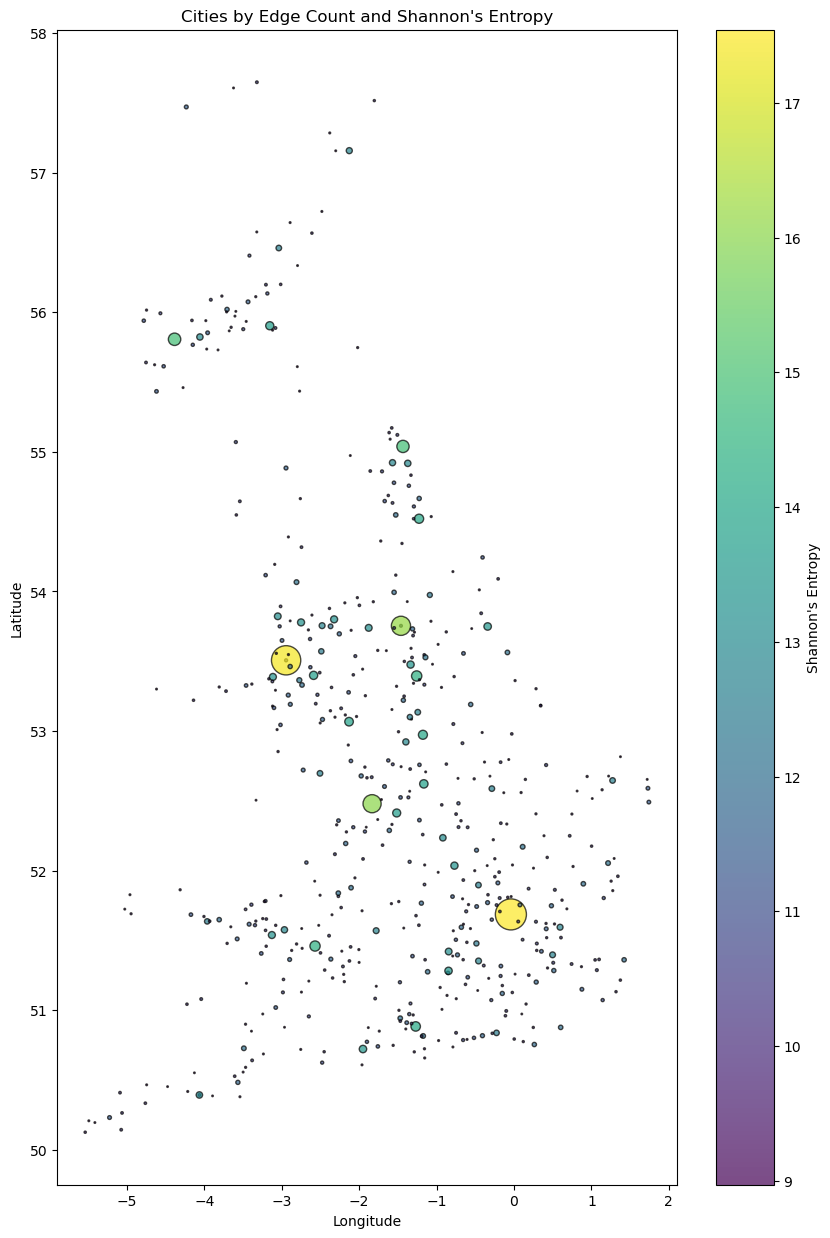

In [111]:
# Plot the cities with circle size based on edge count and color based on Shannon's entropy
fig, ax = plt.subplots(figsize=(10, 15))
sc = ax.scatter(
    city_aggregated['centroid_x'], city_aggregated['centroid_y'],
    s=city_aggregated['size_scaled'],
    c=city_aggregated['avg_shannons_entropy'],
    cmap='viridis', alpha=0.7, edgecolor='k'
)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Shannon's Entropy")

# Add labels and title
ax.set_title("Cities by Edge Count and Shannon's Entropy")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [26]:
def calculate_shannon_entropy(values, num_bins=100):
    """
    Calculate Shannon's entropy for a given array of values.
    """
    # Create a histogram
    histogram, bin_edges = np.histogram(values, bins=num_bins, density=True)
    probabilities = histogram * np.diff(bin_edges)  # Convert counts to probabilities
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Adding a small value to avoid log(0)
    return entropy

# Calculate entropy for each city category
entropy_results = []

for category in result_gdf['city_category'].unique():
    subset = result_gdf[result_gdf['city_category'] == category]
    if not subset.empty:
        entropy = calculate_shannon_entropy(subset['orientation_order'].values)
        entropy_results.append({'city_category': category, 'entropy': entropy})

# Convert the results to a DataFrame
entropy_df = pd.DataFrame(entropy_results)
print(entropy_df)

    city_category   entropy
0             1.0  4.708548
1             3.0  1.601091
2             7.0  4.849396
3             8.0  5.018439
4             6.0  4.257546
5             5.0  4.347646
6             0.0  3.672684
7             4.0  5.070044
8            10.0  4.586198
9             2.0  4.569358
10            9.0  1.998799


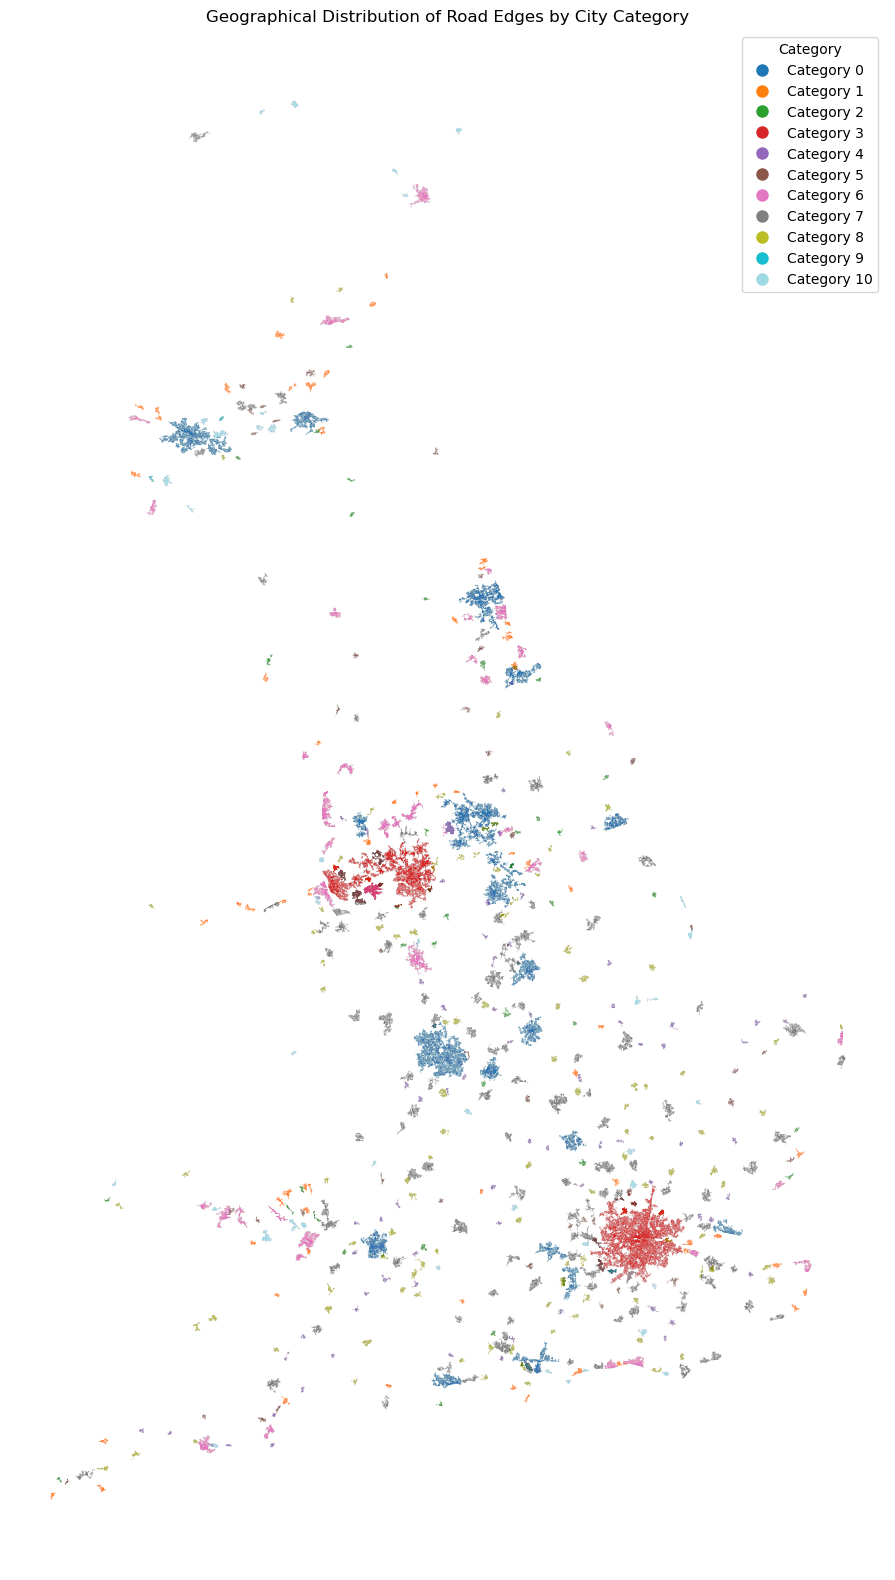

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

# Ensure that 'cluster_no' column does not have NaN values
result_gdf = result_gdf.dropna(subset=['cluster_no'])

# Convert cluster_no to integer
result_gdf['cluster_no'] = result_gdf['cluster_no'].astype(int)

# Create a colormap
cmap = plt.get_cmap('tab20')
norm = mcolors.Normalize(vmin=result_gdf['cluster_no'].min(), vmax=result_gdf['cluster_no'].max())

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 20))

# Plot each cluster with a unique color
for cluster_no in sorted(result_gdf['cluster_no'].unique()):
    cluster_gdf = result_gdf[result_gdf['cluster_no'] == cluster_no]
    color = cmap(norm(cluster_no))
    cluster_gdf.plot(ax=ax, color=color, linewidth=0.05, label=f'Category {cluster_no}')

# Create custom legend with circles
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(cluster_no)), markersize=10, label=f'Category {cluster_no}')
           for cluster_no in sorted(result_gdf['cluster_no'].unique())]

# Add legend and title
ax.legend(handles=handles, loc='upper right', title='Category')
plt.title('Geographical Distribution of Road Edges by City Category')
ax.set_axis_off()

# Show the plot
plt.show()

NameError: name 'G' is not defined

In [73]:
import numpy as np
import pandas as pd

# Group data by city
grouped = result_gdf.groupby('cluster_no')